# Задание 4 - Перенос обучения (transfer learning) и тонкая настройка (fine-tuning)

Одной из важнейшних техник в тренировке сетей - использовать заранее натренированные веса на более общей задачи в качестве начальной точки, а потом "дотренировать" их на конкретной.

Такой подход и убыстряет обучение, и позволяет тренировать эффективные модели на маленьких наборах данных.

В этом упражнении мы натренируем классификатор, который отличает хотдоги от не хотдогов!  
(более подробно - https://www.youtube.com/watch?v=ACmydtFDTGs)

Это задание требует доступа к GPU, поэтому его можно выполнять либо на компьютере с GPU от NVidia, либо в [Google Colab](https://colab.research.google.com/).

In [1]:
import json
import os
import csv
import urllib
from io import BytesIO
from PIL import Image

from socket import timeout

# from google.colab import files
#from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
#platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
#accelerator = 'cu80' if path.exists('/opt/bin/nvidia-smi') else 'cpu'
# !pip3 install -q torch torchvision
# !pip3 install -q Pillow==4.0.0

Сначала давайте скачаем данные с картинками. Это сделает код в следующей ячейке. Данные будут разделены на две части. На обучающей выборке, которая будет храниться в папке **train_kaggle**, мы будем строить наши модели, а на тестовой выборке **test_kaggle** будем предсказывать класс, к которому относится фотография (хотдог или нет).

### Если вы в Google Colab!

В нем можно запускать ноутбуки с доступом к GPU. Они не очень быстрые, зато бесплатные!
Каждый ноутбук получает свой собственный environment c доступным диском итд.

Через 90 минут отсуствия активности этот environment пропадает со всеми данными.
Поэтому нам придется скачивать данные каждый раз.

In [2]:
# Download train data
# !wget "https://www.dropbox.com/s/cupinvuotopehty/train.zip?dl=0"
# !unzip -q "train.zip?dl=0"

# local_folder = "../../HotDogOrNot/content/train_kaggle/"

# train_folder = "train_kaggle/"
train_folder = "data/train_kaggle/"

# Count number of files in the train folder, should be 4603
print('Number of files in the train folder', len(os.listdir(train_folder)))

# Download test data
# !wget "https://www.dropbox.com/s/7xakfl2r9gn5p1j/test.zip?dl=0"
# !unzip -q "test.zip?dl=0"

# test_folder = "test_kaggle/"
test_folder = "data/test_kaggle/"

# Count number of files in the test folder, should be 1150
print('Number of files in the test folder', len(os.listdir(test_folder)))

Number of files in the train folder 4603
Number of files in the test folder 1150


In [3]:
import torch
from torchvision import models
from torch.utils.data import Dataset, SubsetRandomSampler
from torchvision import transforms

import PIL

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

device = torch.device("cuda:0") # Let's make sure GPU is available!

# Имплементируем свой Dataset для загрузки данных

В этом задании мы реализуем свой собственный класс Dataset для загрузки данных. Его цель - загрузить данные с диска и выдать по ним тензор с входом сети, меткой и идентификатором картинки (так будет проще подготовить сабмит для kaggle на тестовых данных).

Вот ссылка, где хорошо объясняется как это делать на примере: https://pytorch.org/tutorials/beginner/data_loading_tutorial.html

Ваш Dataset должен в качестве количества сэмплов выдать количество файлов в папке и уметь выдавать кортеж из сэмпла, метки по индексу и названия файла.
Если название файла начинается со слов 'frankfurter', 'chili-dog' или 'hotdog' - метка положительная. Иначе отрицательная (ноль).

И не забудьте поддержать возможность трансформации входа (аргумент `transforms`), она нам понадобится!

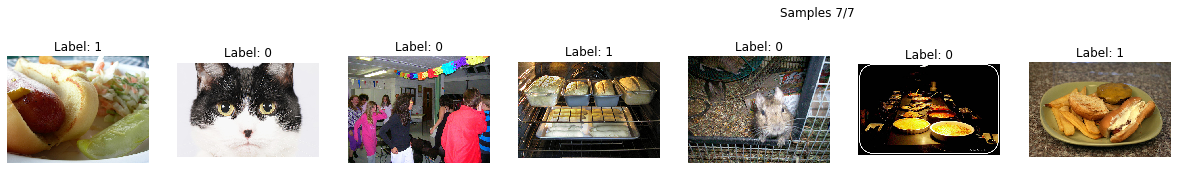

In [4]:
class HotdogOrNotDataset(Dataset):
    def __init__(self, folder, transform=None):
        self.transform = transform
        
        # TODO: Your code here!
        self.folder = folder
        self.file_list = [f for f in os.listdir(folder) if os.path.isfile(os.path.join(folder, f))]
        
    def __len__(self):
        # raise Exception("Not implemented!")
        return len(self.file_list)
    
    def __getitem__(self, index):        
        # TODO Implement getting item by index
        # Hint: os.path.join is helpful!
        # raise Exception("Not implemented!")
        file = self.file_list[index]
        img = Image.open(os.path.join(self.folder,file))
        try:
            y_name, img_id = os.path.splitext(file)[0].split('_')
        except ValueError:
            img_id = file
            y_name = 0
        if img_id == '':
            y_name, img_id = None, y_name
        y = 1 if y_name in ['frankfurter', 'chili-dog', 'hotdog'] else 0
        
        if self.transform:
            img = self.transform(img)
        
        return img, y, img_id

def visualize_samples(dataset, indices, title=None, count=10):
    # visualize random 10 samples
    plt.figure(figsize=(count*3,3))
    display_indices = indices[:count]
    if title:
        plt.suptitle("%s %s/%s" % (title, len(display_indices), len(indices)))        
    for i, index in enumerate(display_indices):    
        x, y, _ = dataset[index]
        plt.subplot(1,count,i+1)
        plt.title("Label: %s" % y)
        plt.imshow(x)
        plt.grid(False)
        plt.axis('off')   
    
orig_dataset = HotdogOrNotDataset(train_folder)
indices = np.random.choice(np.arange(len(orig_dataset)), 7, replace=False)

visualize_samples(orig_dataset, indices, "Samples")

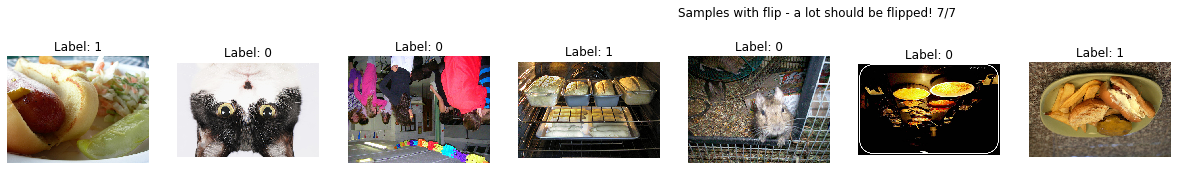

In [5]:
# Let's make sure transforms work!
dataset = HotdogOrNotDataset(train_folder, transform=transforms.RandomVerticalFlip(0.9))

visualize_samples(dataset, indices, "Samples with flip - a lot should be flipped!")

# Создаем Dataset для тренировки

И разделяем его на train и validation.
На train будем обучать модель, на validation проверять ее качество, а соревнование Kaggle In-Class проведем на фотографиях из папки test_kaggle.

In [6]:
# First, lets load the dataset
train_dataset = HotdogOrNotDataset(train_folder, 
                       transform=transforms.Compose([
                           transforms.Resize((224, 224)),
                           transforms.ToTensor(),
                           # Use mean and std for pretrained models
                           # https://pytorch.org/docs/stable/torchvision/models.html
                           transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])                         
                       ])
                      )
test_dataset = HotdogOrNotDataset(test_folder, 
                       transform=transforms.Compose([
                           transforms.Resize((224, 224)),
                           transforms.ToTensor(),
                           # Use mean and std for pretrained models
                           # https://pytorch.org/docs/stable/torchvision/models.html
                           transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])                         
                       ])
                      )

In [7]:
batch_size = 64

data_size = len(dataset)
validation_fraction = .2


val_split = int(np.floor((validation_fraction) * data_size))
indices = list(range(data_size))
np.random.seed(42)
np.random.shuffle(indices)

val_indices, train_indices = indices[:val_split], indices[val_split:]

train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, 
                                           sampler=train_sampler)
val_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                         sampler=val_sampler)
# Notice that we create test data loader in a different way. We don't have the labels.
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)

Наши обычные функции для тренировки

In [8]:
def train_model(model, train_loader, val_loader, loss, optimizer, num_epochs):    
    loss_history = []
    train_history = []
    val_history = []
    for epoch in range(num_epochs):
        model.train() # Enter train mode
        
        loss_accum = 0
        correct_samples = 0
        total_samples = 0
        for i_step, (x, y,_) in enumerate(train_loader):
          
            x_gpu = x.to(device)
            y_gpu = y.to(device)
            prediction = model(x_gpu)    
            loss_value = loss(prediction, y_gpu)
            optimizer.zero_grad()
            loss_value.backward()
            optimizer.step()
            
            _, indices = torch.max(prediction, 1)
            correct_samples += torch.sum(indices == y_gpu)
            total_samples += y.shape[0]
            
            loss_accum += loss_value

        ave_loss = loss_accum / i_step
        train_accuracy = float(correct_samples) / total_samples
        val_accuracy = compute_accuracy(model, val_loader)
        
        loss_history.append(float(ave_loss))
        train_history.append(train_accuracy)
        val_history.append(val_accuracy)
        
        print("Average loss: %f, Train accuracy: %f, Val accuracy: %f" % (ave_loss, train_accuracy, val_accuracy))
        
    return loss_history, train_history, val_history
        
def compute_accuracy(model, loader):
    """
    Computes accuracy on the dataset wrapped in a loader
    
    Returns: accuracy as a float value between 0 and 1
    """
    # model.eval() # Evaluation mode
    # TODO: Copy implementation from previous assignment
    # Don't forget to move the data to device before running it through the model!
    # raise Exception("Not implemented")
    correct = 0
    total_samples = 0
    with torch.no_grad():
        for x, y, _ in loader:
            model.eval()
            x_gpu = x.to(device, non_blocking=True)
            y_gpu = y.to(device, non_blocking=True)
            total_samples += y.shape[0]
            prediction = torch.argmax(model(x_gpu), dim=1)
            correct += torch.sum(prediction == y_gpu)

    return float(correct)/total_samples

# Использование заранее натренированной сети (pretrained network)

Чаще всего в качестве заранее натренированной сети используется сеть, натренированная на данных ImageNet с 1M изображений и 1000 классами.

PyTorch включает такие натренированные сети для различных архитектур (https://pytorch.org/docs/stable/torchvision/models.html)  
Мы будем использовать ResNet18.

Для начала посмотрим, что выдает уже натренированная сеть на наших картинках. То есть, посмотрим к какому из 1000 классов их отнесет сеть.

Запустите модель на 10 случайных картинках из датасета и выведите их вместе с классами с наибольшей вероятностью.  
В коде уже есть код, который формирует соответствие между индексами в выходном векторе и классами ImageNet.

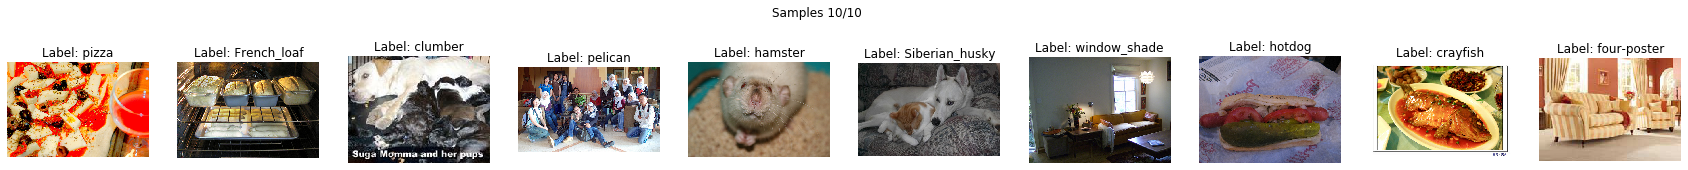

In [9]:
# Thanks to https://discuss.pytorch.org/t/imagenet-classes/4923/2
def load_imagenet_classes():
    classes_json = urllib.request.urlopen('https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json').read()
    classes = json.loads(classes_json)
    
    # TODO: Process it to return dict of class index to name
    return { int(k): v[-1] for k, v in classes.items()}
    
model = models.resnet18(pretrained=True)

# TODO: Run this model on 10 random images of your dataset and visualize what it predicts

indices = np.random.choice(np.arange(len(train_dataset)), 10, replace=False)

X_samplers = [HotdogOrNotDataset(train_folder)[index][0] for index in indices]
X = torch.stack([train_dataset[index][0] for index in indices])

with torch.no_grad():
    model.eval()
    predictions = torch.argmax(model(X), dim=1)

imagenet_clases = load_imagenet_classes()
predictions_class = [imagenet_clases[p.item()] for p in predictions]
visualize_samples(list(zip(X_samplers,predictions_class,predictions)), list(range(len(predictions))), "Samples")


# Перенос обучения (transfer learning) - тренировать только последний слой

Существует несколько вариантов переноса обучения, мы попробуем основные.  
Первый вариант - заменить последний слой на новый и тренировать только его, заморозив остальные.

In [10]:
import torch.nn as nn
import torch.optim as optim

model_lr = models.resnet18(pretrained=True)
# TODO: Freeze all the layers of this model and add a new output layer
# https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

for param in model_lr.parameters():
    param.requires_grad = False

num_ftrs = model_lr.fc.in_features
model_lr.fc = nn.Linear(num_ftrs, 2)

model_lr.type(torch.cuda.FloatTensor)
model_lr.to(device)

parameters = model_lr.fc.parameters()   # Fill the right thing here!

loss = nn.CrossEntropyLoss()
optimizer = optim.SGD( parameters, lr=0.001, momentum=0.9)
loss_history, train_history, val_history = train_model(model_lr, train_loader, val_loader, loss, optimizer, 10)

Average loss: 0.365698, Train accuracy: 0.838447, Val accuracy: 0.907609
Average loss: 0.195495, Train accuracy: 0.933478, Val accuracy: 0.931522
Average loss: 0.174554, Train accuracy: 0.933750, Val accuracy: 0.931522
Average loss: 0.164453, Train accuracy: 0.935922, Val accuracy: 0.938043
Average loss: 0.162110, Train accuracy: 0.936465, Val accuracy: 0.942391
Average loss: 0.154912, Train accuracy: 0.938908, Val accuracy: 0.935870
Average loss: 0.144243, Train accuracy: 0.943796, Val accuracy: 0.946739
Average loss: 0.146037, Train accuracy: 0.944339, Val accuracy: 0.948913
Average loss: 0.147136, Train accuracy: 0.945153, Val accuracy: 0.947826
Average loss: 0.148272, Train accuracy: 0.944339, Val accuracy: 0.947826


# Перенос обучения (transfer learning) - тренировать всю модель

Второй вариант - точно так же заменить последгний слой на новый и обучать всю модель целиком.

In [11]:
import torch.nn as nn
import torch.optim as optim

model_al = models.resnet18(pretrained=True)
# TODO: Add a new output layer and train the whole model
# https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html
num_ftrs = model_al.fc.in_features
model_al.fc = nn.Linear(num_ftrs, 2)

model_al.type(torch.cuda.FloatTensor)
model_al.to(device)

parameters = model_al.parameters()   # Fill the right thing here!

loss = nn.CrossEntropyLoss()
optimizer = optim.SGD( parameters, lr=0.001, momentum=0.9)

loss_history, train_history, val_history = train_model(model_al, train_loader, val_loader, loss, optimizer, 10)

Average loss: 0.298331, Train accuracy: 0.867499, Val accuracy: 0.942391
Average loss: 0.138476, Train accuracy: 0.947054, Val accuracy: 0.944565
Average loss: 0.097917, Train accuracy: 0.966060, Val accuracy: 0.944565
Average loss: 0.072684, Train accuracy: 0.979093, Val accuracy: 0.946739
Average loss: 0.046994, Train accuracy: 0.987239, Val accuracy: 0.945652
Average loss: 0.038394, Train accuracy: 0.990497, Val accuracy: 0.945652
Average loss: 0.027686, Train accuracy: 0.995113, Val accuracy: 0.948913
Average loss: 0.022390, Train accuracy: 0.996199, Val accuracy: 0.950000
Average loss: 0.012956, Train accuracy: 0.999457, Val accuracy: 0.946739
Average loss: 0.010271, Train accuracy: 0.999728, Val accuracy: 0.947826


# Перенос обучения (transfer learning) - разные скорости обучения для разных слоев

И наконец последний вариант, который мы рассмотрим - использовать разные скорости обучения для новых и старых слоев

In [12]:
import torch.nn as nn
import torch.optim as optim

model_ald = models.resnet18(pretrained=True)
# TODO: Add a new output layer
# Train new layer with learning speed 0.001 and old layers with 0.0001
# https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

num_ftrs = model_ald.fc.in_features
model_ald.fc = nn.Linear(num_ftrs, 2)

model_ald.type(torch.cuda.FloatTensor)
model_ald.to(device)
my_layer = ['fc.weight', 'fc.bias']
my_layer_parameters = list(
    filter(lambda kv: kv[0] in my_layer, model_ald.named_parameters()))
my_layer_parameters = [par[1] for par in my_layer_parameters]
other_layer_parameters = list(
    filter(lambda kv: kv[0] not in my_layer, model_ald.named_parameters()))
other_layer_parameters = [par[1] for par in other_layer_parameters]

loss = nn.CrossEntropyLoss()

# optimizer = None # Hint - look into what PyTorch optimizers let you configure!
optimizer = optim.SGD([
    {"params": my_layer_parameters, "lr": 0.001},
    {"params": other_layer_parameters},
],
    lr=0.0001, momentum=0.9)
loss_history, train_history, val_history = train_model(
    model_ald, train_loader, val_loader, loss, optimizer, 10)

Average loss: 0.347466, Train accuracy: 0.848222, Val accuracy: 0.926087
Average loss: 0.190879, Train accuracy: 0.928319, Val accuracy: 0.939130
Average loss: 0.160488, Train accuracy: 0.941352, Val accuracy: 0.945652
Average loss: 0.153064, Train accuracy: 0.940538, Val accuracy: 0.940217
Average loss: 0.137624, Train accuracy: 0.946239, Val accuracy: 0.944565
Average loss: 0.122791, Train accuracy: 0.954113, Val accuracy: 0.943478
Average loss: 0.116117, Train accuracy: 0.957915, Val accuracy: 0.948913
Average loss: 0.106484, Train accuracy: 0.958729, Val accuracy: 0.941304
Average loss: 0.110294, Train accuracy: 0.955471, Val accuracy: 0.952174
Average loss: 0.098430, Train accuracy: 0.963617, Val accuracy: 0.944565


# Визуализируем метрики и ошибки модели

Попробуем посмотреть, где модель ошибается - визуализируем ложные срабатывания (false positives) и ложноотрицательные срабатывания (false negatives).

Для этого мы прогоним модель через все примеры и сравним ее с истинными метками (ground truth).

In [18]:
from torch.utils.data.sampler import Sampler

class SubsetSampler(Sampler):
    r"""Samples elements with given indices sequentially

    Arguments:
        data_source (Dataset): dataset to sample from
        indices (ndarray): indices of the samples to take
    """

    def __init__(self, indices):
        self.indices = indices

    def __iter__(self):
        return (self.indices[i] for i in range(len(self.indices)))

    def __len__(self):
        return len(self.indices)
    
    
def evaluate_model(model, dataset, indices):
    """
    Computes predictions and ground truth labels for the indices of the dataset
    
    Returns: 
    predictions: np array of booleans of model predictions
    grount_truth: np array of boolean of actual labels of the dataset
    """
    # model.eval() # Evaluation mode
    sampler = SubsetSampler(indices)
    loader = torch.utils.data.DataLoader(dataset, batch_size=16,
                                         sampler=sampler)
    
    # TODO: Evaluate model on the list of indices and capture predictions
    # and ground truth labels
    # Hint: SubsetSampler above could be useful!
    
    # raise Exception("Not implemented")
    predictions = []
    ground_truth = []
    with torch.no_grad():
        model.eval()
        for x, y, _ in loader:
            x_gpu = x.to(device, non_blocking=True)
            y_gpu = y.to(device, non_blocking=True)
            predictions.extend(torch.argmax(model(x_gpu), dim=1).tolist())
            ground_truth.extend(y.tolist())
    
    predictions = np.array(predictions)
    ground_truth = np.array(ground_truth)
    return predictions, ground_truth

predictions, gt = evaluate_model(model_ald, train_dataset, val_indices)

NameError: name 'model_ald' is not defined

И теперь можно визуализировать false positives и false negatives.

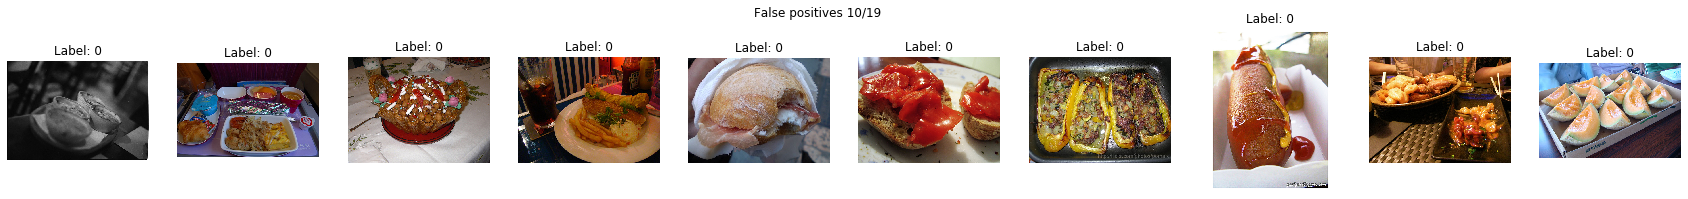

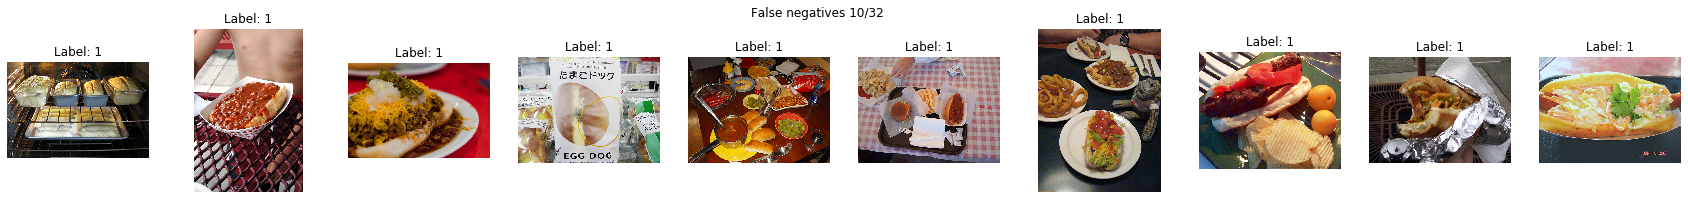

In [14]:
# TODO: Compute indices of the false positives on the validation set.
# Note those have to be indices of the original dataset
false_positive_indices = np.array(val_indices)[np.logical_and(predictions == 1, gt == 0)]
visualize_samples(orig_dataset, false_positive_indices, "False positives")

# TODO: Compute indices of the false negatives on the validation set.
# Note those have to be indices of the original dataset
false_negatives_indices = np.array(val_indices)[np.logical_and(predictions == 0, gt == 1)]
visualize_samples(orig_dataset, false_negatives_indices, "False negatives")


In [9]:
import sklearn.metrics as metrics
def binary_classification_metrics(prediction, ground_truth):
    # TODO: Implement this function!
    # We did this already it in the assignment1
    TP = np.sum(np.logical_and(prediction == 1, ground_truth == 1))
    # TN = np.sum(np.logical_and(prediction == 0, ground_truth == 0))
    FP = np.sum(np.logical_and(prediction == 1, ground_truth == 0))
    FN = np.sum(np.logical_and(prediction == 0, ground_truth == 1))
    precision = TP/(TP+FP)
    recall = TP/(TP+FN)
    f1 = 2*precision*recall/(precision+recall)
    return precision, recall, f1

precision, recall, f1 = binary_classification_metrics(predictions, gt)
print("F1: %4.3f, P: %4.3f, R: %4.3f" % (f1, precision, recall))

NameError: name 'predictions' is not defined

# Что будет в конце вы уже поняли

Натренируйте лучшую модель на основе `resnet18`, меняя только процесс тренировки.
Выбирайте лучшую модель по F1 score.

Как всегда, не забываем:
- побольше агментаций!
- перебор гиперпараметров
- различные оптимизаторы
- какие слои тюнить
- learning rate annealing
- на какой эпохе останавливаться

Наша цель - довести F1 score на validation set до значения, большего **0.9**.

In [10]:
def train_model_sh_f1(model_name,model, train_loader, val_loader, loss, optimizer, scheduler, num_epochs):    
    loss_history = []
    train_history = []
    val_history = []
    best_val=0.9
    for epoch in range(num_epochs):
        model.train() # Enter train mode
        
        loss_accum = 0
        tp = 0
        fn = 0
        fp = 0
        for i_step, (x, y,_) in enumerate(train_loader):
#             print(epoch,i_step, 'start', torch.cuda.memory_allocated())
            optimizer.zero_grad()
#             print(epoch,i_step, 'zerro', torch.cuda.memory_allocated())
            x_gpu = x.to(device)
            y_gpu = y.to(device)
#             print(epoch,i_step, 'data', torch.cuda.memory_allocated())
            prediction = model(x_gpu)
#             print(epoch,i_step, 'prediction', torch.cuda.memory_allocated())
            loss_value = loss(prediction, y_gpu)
#             print(epoch,i_step, 'loss', torch.cuda.memory_allocated())
            
            _, indices = torch.max(prediction, 1)
            tp += float(torch.sum((indices==1) &(y_gpu==1)))
            fp += float(torch.sum((indices==1) &(y_gpu==0)))
            fn += float(torch.sum((indices==0) &(y_gpu==1)))
            
            del indices, prediction
#             print(epoch,i_step, 'free memmory', torch.cuda.memory_allocated())
            
            loss_value.backward()
#             print(epoch,i_step, 'backward', torch.cuda.memory_allocated())
            optimizer.step()
            
#             print(epoch,i_step, 'step', torch.cuda.memory_allocated())
            
            loss_accum += float(loss_value)
            del loss_value,x_gpu,y_gpu
#             print(epoch,i_step, 'end', torch.cuda.memory_allocated())

        ave_loss = loss_accum / i_step
        precision = tp/(tp+fp)
        recall = tp/(tp+fn)
        f1 = 2*precision*recall/(precision+recall)
        val_f1 = compute_f1(model, val_loader)
        
        if val_f1>best_val:
            best_val=val_f1
            torch.save(model.state_dict(), 'data/models/model_'+model_name+'_'+str(val_f1)+'.pt')
        scheduler.step(val_f1)
        
        loss_history.append(float(ave_loss))
        train_history.append(f1)
        val_history.append(val_f1)
        
        print("Average loss: %f, Train f1: %f, Val f1: %f" % (ave_loss, f1, val_f1))
        
    return loss_history, train_history, val_history

def compute_f1(model, loader):
    """
    Computes accuracy on the dataset wrapped in a loader
    
    Returns: accuracy as a float value between 0 and 1
    """
    # model.eval() # Evaluation mode
    # TODO: Copy implementation from previous assignment
    # Don't forget to move the data to device before running it through the model!
    # raise Exception("Not implemented")
    tp = 0
    fn = 0
    fp = 0
    with torch.no_grad():
        model.eval()
        for x, y, _ in loader:
            x_gpu = x.to(device)
            y_gpu = y.to(device)
            prediction = torch.argmax(model(x_gpu), dim=1)
            tp += float(torch.sum((prediction==1) &(y_gpu==1)))
            fp += float(torch.sum((prediction==1) &(y_gpu==0)))
            fn += float(torch.sum((prediction==0) &(y_gpu==1)))

    precision = tp/(tp+fp)
    recall = tp/(tp+fn)
    return 2*precision*recall/(precision+recall)

In [57]:
import torch.nn as nn
import torch.optim as optim

tfs = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ColorJitter(hue=.20, saturation=.20),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(50, resample=PIL.Image.BILINEAR),
    transforms.ToTensor(),
    # Use mean and std for pretrained models
    # https://pytorch.org/docs/stable/torchvision/models.html
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])
train_dataset_aug = HotdogOrNotDataset(train_folder, transform=tfs)
train_loader_aug = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                               sampler=train_sampler)
model_name = 'resnet18_lr'
model = models.resnet18(pretrained=True)

for param in model.parameters():
    param.requires_grad = False

num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)

model.type(torch.cuda.FloatTensor)
model.to(device)

parameters = model.fc.parameters()   # Fill the right thing here!

loss = nn.CrossEntropyLoss()
optimizer = optim.Adadelta(parameters, lr=1, weight_decay=1e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max',
                                                 factor=0.1, patience=2,
                                                 verbose=True)

loss_history, train_history, val_history = train_model_sh_f1(model_name,
    model, train_loader_aug, val_loader, loss, optimizer, scheduler, 25)

Average loss: 0.348983, Train f1: 0.729433, Val f1: 0.893617
Average loss: 0.197043, Train f1: 0.880072, Val f1: 0.920437
Average loss: 0.194022, Train f1: 0.871473, Val f1: 0.885057
Average loss: 0.172908, Train f1: 0.895749, Val f1: 0.929032
Average loss: 0.161591, Train f1: 0.899371, Val f1: 0.925040
Average loss: 0.160026, Train f1: 0.898267, Val f1: 0.929487
Average loss: 0.156277, Train f1: 0.900402, Val f1: 0.870337
Average loss: 0.152802, Train f1: 0.901559, Val f1: 0.916793
Epoch     8: reducing learning rate of group 0 to 1.0000e-01.
Average loss: 0.160965, Train f1: 0.898796, Val f1: 0.862254
Average loss: 0.122238, Train f1: 0.922937, Val f1: 0.930533
Average loss: 0.121801, Train f1: 0.921088, Val f1: 0.930533
Average loss: 0.111226, Train f1: 0.928699, Val f1: 0.930533
Epoch    12: reducing learning rate of group 0 to 1.0000e-02.
Average loss: 0.117569, Train f1: 0.922252, Val f1: 0.930533
Average loss: 0.112679, Train f1: 0.933810, Val f1: 0.927066
Average loss: 0.109921

KeyboardInterrupt: 

In [ ]:
with open('data/models/model_'+model_name+'.info', 'wb') as f:
    pickle.dump(loss_history, f)
    pickle.dump(train_history, f)
    pickle.dump(val_history, f)

In [16]:
import torch.nn as nn
import torch.optim as optim

tfs = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ColorJitter(hue=.20, saturation=.20),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(50, resample=PIL.Image.BILINEAR),
    transforms.ToTensor(),
    # Use mean and std for pretrained models
    # https://pytorch.org/docs/stable/torchvision/models.html
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])
train_dataset_aug = HotdogOrNotDataset(train_folder, transform=tfs)
train_loader_aug = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                               sampler=train_sampler)
model_name = 'resnet18_lrd'
model = models.resnet18(pretrained=True)

num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)

model.type(torch.cuda.FloatTensor)
model.to(device)
my_layer = ['fc.weight', 'fc.bias']
my_layer_parameters = list(
    filter(lambda kv: kv[0] in my_layer, model.named_parameters()))
my_layer_parameters = [par[1] for par in my_layer_parameters]
other_layer_parameters = list(
    filter(lambda kv: kv[0] not in my_layer, model.named_parameters()))
other_layer_parameters = [par[1] for par in other_layer_parameters]

loss = nn.CrossEntropyLoss()

# optimizer = None # Hint - look into what PyTorch optimizers let you configure!
optimizer = optim.Adadelta([
    {"params": my_layer_parameters, "lr": 1},
    {"params": other_layer_parameters},
],
    lr=0.0001,weight_decay=1e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max',
                                                 factor=0.1, patience=2,
                                                 verbose=True)

loss_history, train_history, val_history = train_model_sh_f1(model_name,
    model, train_loader_aug, val_loader, loss, optimizer, scheduler, 50)

Average loss: 0.339137, Train f1: 0.752113, Val f1: 0.880829
Average loss: 0.206539, Train f1: 0.864841, Val f1: 0.813158
Average loss: 0.183815, Train f1: 0.887097, Val f1: 0.909396
Average loss: 0.166181, Train f1: 0.893980, Val f1: 0.891192
Average loss: 0.155694, Train f1: 0.899729, Val f1: 0.914573
Average loss: 0.154464, Train f1: 0.898876, Val f1: 0.930818
Average loss: 0.146292, Train f1: 0.906264, Val f1: 0.932907
Average loss: 0.159979, Train f1: 0.898434, Val f1: 0.859527
Average loss: 0.155233, Train f1: 0.896156, Val f1: 0.890815
Epoch     9: reducing learning rate of group 0 to 1.0000e-01.
Epoch     9: reducing learning rate of group 1 to 1.0000e-05.
Average loss: 0.156421, Train f1: 0.905593, Val f1: 0.853526
Average loss: 0.125444, Train f1: 0.913343, Val f1: 0.929487
Average loss: 0.117258, Train f1: 0.928540, Val f1: 0.921824
Epoch    12: reducing learning rate of group 0 to 1.0000e-02.
Epoch    12: reducing learning rate of group 1 to 1.0000e-06.
Average loss: 0.1074

KeyboardInterrupt: 

In [14]:
import torch.nn as nn
import torch.optim as optim

tfs = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ColorJitter(hue=.20, saturation=.20),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(50, resample=PIL.Image.BILINEAR),
    transforms.ToTensor(),
    # Use mean and std for pretrained models
    # https://pytorch.org/docs/stable/torchvision/models.html
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])
train_dataset_aug = HotdogOrNotDataset(train_folder, transform=tfs)
train_loader_aug = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                               sampler=train_sampler)
model_name = 'vgg13_lr'
model = models.vgg13_bn(pretrained=True)
for param in model.parameters():
    param.requires_grad = False

num_ftrs = model.classifier[6].in_features
model.classifier[6] = nn.Linear(num_ftrs, 2)

model.type(torch.cuda.FloatTensor)
model.to(device)

parameters = model.classifier[6].parameters()   # Fill the right thing here!

loss = nn.CrossEntropyLoss()
optimizer = optim.Adadelta(parameters, lr=1, weight_decay=1e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max',
                                                 factor=0.1, patience=4,
                                                 verbose=True)

loss_history, train_history, val_history = train_model_sh_f1(model_name,
    model, train_loader_aug, val_loader, loss, optimizer, scheduler, 100)

Average loss: 0.252100, Train f1: 0.831986, Val f1: 0.923077
Average loss: 0.167155, Train f1: 0.892170, Val f1: 0.929260
Average loss: 0.153420, Train f1: 0.902188, Val f1: 0.935229
Average loss: 0.162314, Train f1: 0.903540, Val f1: 0.928571
Average loss: 0.146082, Train f1: 0.915705, Val f1: 0.933116
Average loss: 0.145894, Train f1: 0.919591, Val f1: 0.925373
Average loss: 0.149890, Train f1: 0.902101, Val f1: 0.926829
Epoch     7: reducing learning rate of group 0 to 1.0000e-01.
Average loss: 0.144631, Train f1: 0.916961, Val f1: 0.924031
Average loss: 0.118906, Train f1: 0.929639, Val f1: 0.936102
Average loss: 0.119579, Train f1: 0.928476, Val f1: 0.932907
Average loss: 0.134895, Train f1: 0.923759, Val f1: 0.930979
Average loss: 0.114859, Train f1: 0.934339, Val f1: 0.934609
Average loss: 0.113635, Train f1: 0.932331, Val f1: 0.932039
Average loss: 0.106803, Train f1: 0.933925, Val f1: 0.937600
Average loss: 0.117281, Train f1: 0.924855, Val f1: 0.936102
Average loss: 0.111476,

KeyboardInterrupt: 

In [9]:
import torch.nn as nn
import torch.optim as optim

batch_size = 8

tfs = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ColorJitter(hue=.20, saturation=.20),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(50, resample=PIL.Image.BILINEAR),
    transforms.ToTensor(),
    # Use mean and std for pretrained models
    # https://pytorch.org/docs/stable/torchvision/models.html
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])
train_dataset_aug = HotdogOrNotDataset(train_folder, transform=tfs)
train_loader_aug = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                               sampler=train_sampler)
train_dataset = HotdogOrNotDataset(train_folder, 
                       transform=transforms.Compose([
                           transforms.Resize((224, 224)),
                           transforms.ToTensor(),
                           # Use mean and std for pretrained models
                           # https://pytorch.org/docs/stable/torchvision/models.html
                           transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])                         
                       ])
                      )

val_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                         sampler=val_sampler)

model_name = 'vgg13_lrd'
model = models.vgg13_bn(pretrained=True)

num_ftrs = model.classifier[6].in_features
model.classifier[6] = nn.Linear(num_ftrs, 2)

# model.type(torch.cuda.FloatTensor)
model.to(device)
my_layer = ['classifier.6.weight', 'classifier.6.bias']
my_layer_parameters = list(
    filter(lambda kv: kv[0] in my_layer, model.named_parameters()))
my_layer_parameters = [par[1] for par in my_layer_parameters]
other_layer_parameters = list(
    filter(lambda kv: kv[0] not in my_layer, model.named_parameters()))
other_layer_parameters = [par[1] for par in other_layer_parameters]

# parameters = model.classifier[6].parameters()

loss = nn.CrossEntropyLoss()

optimizer = optim.SGD([
    {"params": my_layer_parameters, "lr": 1e-2},
    {"params": other_layer_parameters},
],
    lr=0.000001,weight_decay=1e-5)
# optimizer = optim.Adadelta(parameters, lr=1e-2, weight_decay=1e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max',
                                                 factor=0.1, patience=4,
                                                 verbose=True)
# print('start', torch.cuda.memory_allocated())
loss_history, train_history, val_history = train_model_sh_f1(model_name,
    model, train_loader_aug, val_loader, loss, optimizer, scheduler, 50)

Average loss: 0.213702, Train f1: 0.854962, Val f1: 0.916933
Average loss: 0.194764, Train f1: 0.874048, Val f1: 0.915980
Average loss: 0.181910, Train f1: 0.879821, Val f1: 0.922830
Average loss: 0.198971, Train f1: 0.871979, Val f1: 0.913621
Average loss: 0.182383, Train f1: 0.883163, Val f1: 0.922118
Average loss: 0.170455, Train f1: 0.884633, Val f1: 0.923588
Average loss: 0.186630, Train f1: 0.881855, Val f1: 0.910959
Average loss: 0.178366, Train f1: 0.883244, Val f1: 0.928230
Average loss: 0.191576, Train f1: 0.881386, Val f1: 0.864407
Average loss: 0.180737, Train f1: 0.891150, Val f1: 0.916944
Average loss: 0.184137, Train f1: 0.879180, Val f1: 0.930308
Average loss: 0.181365, Train f1: 0.885714, Val f1: 0.928571
Average loss: 0.169174, Train f1: 0.884821, Val f1: 0.930693
Average loss: 0.173622, Train f1: 0.896398, Val f1: 0.929487
Average loss: 0.179095, Train f1: 0.886121, Val f1: 0.929487
Average loss: 0.180095, Train f1: 0.887705, Val f1: 0.920204
Average loss: 0.178276, 

In [10]:
del model, loss, optimizer, scheduler, num_ftrs
torch.cuda.empty_cache()

In [ ]:
with open('data/models/model_'+model_name+'.info', 'wb') as f:
    pickle.dump(loss_history, f)
    pickle.dump(train_history, f)
    pickle.dump(val_history, f)

In [11]:
# TODO: Train your best model!
file_name='resnet13'
best_model = models.resnet18(pretrained=True)

num_ftrs = best_model.fc.in_features
best_model.fc = nn.Linear(num_ftrs, 2)
best_model.load_state_dict(torch.load('data/models/model_'+file_name+'_best.pt'))

best_model.type(torch.cuda.FloatTensor)
best_model.to(device)

best_model.eval()

NameError: name 'nn' is not defined

In [23]:
import torch.nn as nn
file_name='vgg13_2'
best_model = models.vgg13_bn(pretrained=True)

num_ftrs = best_model.classifier[6].in_features
best_model.classifier[6] = nn.Linear(num_ftrs, 2)
best_model.load_state_dict(torch.load('data/models/model_'+file_name+'_best.pt'))

best_model.type(torch.cuda.FloatTensor)
best_model.to(device)

best_model.eval()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256, kernel_size=(3, 3)

In [24]:
# Let's check how it performs on validation set!
predictions, ground_truth = evaluate_model(best_model, train_dataset, val_indices)
precision, recall, f1 = binary_classification_metrics(predictions, ground_truth)
print("F1: %4.3f, P: %4.3f, R: %4.3f" % (precision, recall, f1))

# TODO: Visualize training curve for the best model

F1: 0.941, P: 0.929, R: 0.935


## Визуализируйте ошибки лучшей модели

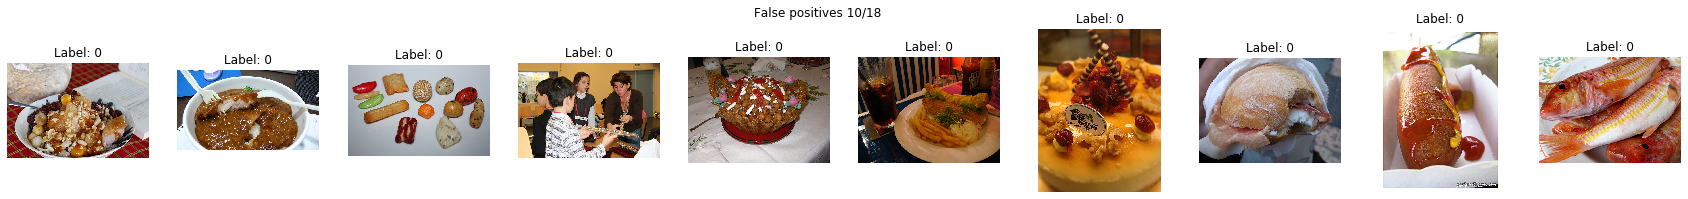

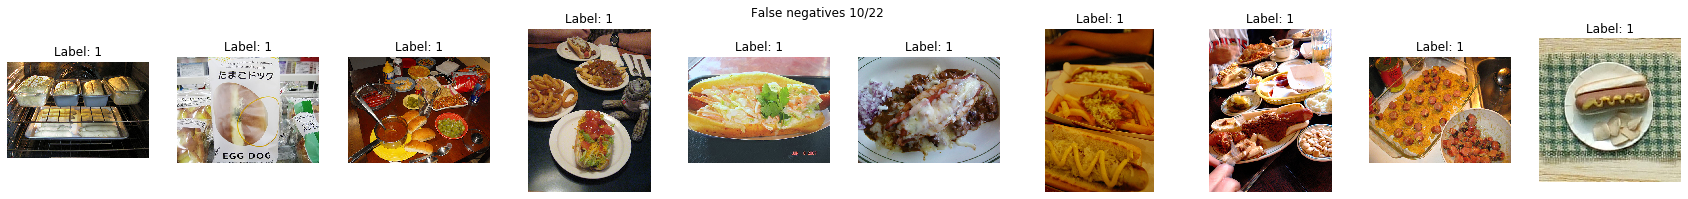

In [25]:
# TODO Visualize false positives and false negatives of the best model on the validation set

false_positive_indices = np.array(val_indices)[np.logical_and(predictions == 1, ground_truth == 0)]
visualize_samples(orig_dataset, false_positive_indices, "False positives")

false_negatives_indices = np.array(val_indices)[np.logical_and(predictions == 0, ground_truth == 1)]
visualize_samples(orig_dataset, false_negatives_indices, "False negatives")

# Необязательное задание с большой звездочкой

Поучавствуйте в Kaggle In-Class Hot Dog Recognition Challenge!  
Это соревнование сделано специально для курса и в нем учавствуют только те, кто проходит курс.

В нем участники соревнуются в качестве натренированных моделей, загружая на сайт предсказания своих моделей на тестовой выборке. Разметка тестовой выборке участникам недоступна.
Более подробно о правилах соревнования ниже.

Те, кто проходят курс лично, за высокое место в соревновании получат дополнительные баллы.

Здесь уже можно использовать и другие базовые архитектуры кроме `resnet18`, и ансамбли, и другие трюки тренировки моделей.

Вот ссылка на соревнование:
https://www.kaggle.com/c/hotdogornot

In [26]:
image_id = []
predictions = []
best_model.eval()
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=16)
for x,_,id_img in test_loader:
    # TODO : Напишите код для предсказания меток (1 = есть хотдог, 0 = хотдога нет)
    # Код должен возвратить список из id картинки и метку predictions
    # image id - это название файла картинки, например '10000.jpg'
    image_id.extend(id_img)
    with torch.no_grad():
        x_gpu = x.to(device, non_blocking=True)
        prediction = torch.argmax(best_model(x_gpu), dim=1)
    predictions.extend(prediction.tolist())


In [27]:
# Так можно создать csv файл, чтобы затем загрузить его на kaggle
# Ожидаемый формат csv-файла:
# image_id,label
# 10000.jpg,1
# 10001.jpg,1
# 10002.jpg,0
# 10003.jpg,1
# 10004.jpg,0

with open('data/subm.csv', 'w') as submissionFile:
    writer = csv.writer(submissionFile)
    writer.writerow(['image_id', 'label'])
    writer.writerows(zip(image_id,predictions))

In [ ]:
# А так можно скачать файл с Google Colab
# files.download('subm.csv') 

In [35]:
resnet18 ={}
with open('data/resnet18.csv', 'r') as infile:
    reader = csv.reader(infile)
    for rows in reader:
        if len(rows)>0:
            if rows[0]=='image_id':
                continue
            resnet18[rows[0]]=rows[1]

vgg13 ={}
with open('data/vgg13.csv', 'r') as infile:
    reader = csv.reader(infile)
    for rows in reader:
        if len(rows)>0:
            if rows[0]=='image_id':
                continue
            vgg13[rows[0]]=rows[1]

vgg13_2 ={}
with open('data/vgg13_2.csv', 'r') as infile:
    reader = csv.reader(infile)
    for rows in reader:
        if len(rows)>0:
            if rows[0]=='image_id':
                continue
            vgg13_2[rows[0]]=rows[1]

image_ids = []
predictions = []
for image_id in resnet18:
    image_ids.append(image_id)
    prediction = int((int(resnet18[image_id])+int(vgg13[image_id])+int(vgg13_2[image_id]))/3+0.5)
    predictions.append(prediction)
    
with open('data/subm.csv', 'w') as submissionFile:
    writer = csv.writer(submissionFile)
    writer.writerow(['image_id', 'label'])
    writer.writerows(zip(image_ids,predictions))

### Небольшое введение в Kaggle для тех, кто не слышал об этой платформе раньше

В основе своей Kaggle - это платформа для проведения соревнований по машинному обучению. Появилась она в 2010 и, пожалуй, стала самой популярной и известной из всех существующих площадок по машинному обучению. Надо сказать, что Kaggle - это не только соревнования, но и сообщество людей, увлеченных машинным обучением. А судя по Википедии, в 2017 году отметка зарегистрированных пользователей перевалила за миллион. Есть там и обучающие материалы, возможность задавать вопросы, делиться кодом и идеями - просто мечта. 

### Как проходят соревнования? 
Обычно участники скачивают данные для обучения моделей (train data), чтобы затем делать предсказания на тестовых данных (test data). Обучающая выборка содержит как сами данные, так и правильные метки (значения зависимой переменной), чтобы можно было обучить модель. Но тестовые данные ответа не содержат - и нашей целью является предсказание меток по имеющимся данным. Файл с ответами для каждого наблюдения из тестовой выборки загружается на Kaggle и оценивается в соответствии с выбранной метрикой соревнования, а результат является публичным и показывается в общей таблице (ее называют еще лидербордом - leaderboard) - чтобы появилось желание посоревноваться и создать еще более сильную модель. В "настоящих" соревнованиях, которые проходят на Kaggle, есть и денежное вознаграждение для тех участников, кто занимает первые места на лидерборде. Например, в [этом](https://www.kaggle.com/c/zillow-prize-1#description) соревновании, человек, занявший первое место, получил около 1 000 000 долларов. 

Тестовые данные делятся случайным образом в некоторой пропорции. И пока соревнование идет, на лидерборде показываются очки и рейтинг участников только по одной части (Public Leaderboard). А вот когда соревнование заканчивается, то рейтинг участников составляется по второй части тестовых данных (Private Leaderboard). И часто можно видеть, как люди занимавшие первые места на публичной части тестовых данных, оказываются далеко не первыми на закрытой части тестовых данных. Зачем это сделано? Есть несколько причин, но, пожалуй, самой фундаментальной является идея недообучения-переобучения. Всегда возможно, что наша модель настроилась на конкретную выборку, но как она поведет себя на тех данных, которые еще не видела? Разбиение тестовых данных на публичную и скрытую части сделано для того, чтобы отобрать модели, которые имеют большую обобщающую способность. Одним из лозунгов участников соревнований стал "Доверяйте своей локальной кросс-валидации" (Trust your CV!). Есть очень большой соблазн оценивать свою модель по публичной части лидерборда, но лучшей стратегией будет выбирать ту модель, которая дает лучшую метрику на кросс-валидации на обучающей выборке. 

В нашем соревновании публичная часть лидерборда составляет 30%, а скрытая 70%. Вы можете делать до двух попыток в день, а оцениваться попытки будут по F1-мере. Удачи и доверяйте своей локальной валидации! В конце соревнования у вас будет возможность выбрать 2 из всех совершенных попыток - лучшая из этих двух и будет засчитана вам на скрытой части тестовых данных.